In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
import math
import requests
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from tensorflow.keras.applications import InceptionResNetV2,InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

In [8]:
img_h = img_w = 224
dims = (224,224)
batch_size = 32

In [11]:
train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    #data augmentation
    rotation_range = 15,
    zoom_range = (0.95, 0.95),
    horizontal_flip = True,
    vertical_flip = True
)

In [12]:
val_datagen = ImageDataGenerator(rescale = 1.0/255)

In [13]:
test_datagen = ImageDataGenerator(rescale = 1.0/255)

In [14]:
train = train_datagen.flow_from_directory(
    "train/",
    target_size = dims,
    batch_size = batch_size,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 123
)

Found 7946 images belonging to 70 classes.


In [15]:
val = val_datagen.flow_from_directory(
    "valid/",
    target_size = dims,
    batch_size = batch_size,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 123
)

Found 700 images belonging to 70 classes.


In [16]:
test = test_datagen.flow_from_directory(
    "test/",
    target_size = dims,
    batch_size = batch_size,
    color_mode = 'rgb',
    class_mode = 'categorical',
    seed = 123
)

Found 700 images belonging to 70 classes.


In [17]:
label_mapper = np.asarray(list(train.class_indices.keys()))
label_mapper

array(['Afghan', 'African Wild Dog', 'Airedale', 'American Hairless',
       'American Spaniel', 'Basenji', 'Basset', 'Beagle',
       'Bearded Collie', 'Bermaise', 'Bichon Frise', 'Blenheim',
       'Bloodhound', 'Bluetick', 'Border Collie', 'Borzoi',
       'Boston Terrier', 'Boxer', 'Bull Mastiff', 'Bull Terrier',
       'Bulldog', 'Cairn', 'Chihuahua', 'Chinese Crested', 'Chow',
       'Clumber', 'Cockapoo', 'Cocker', 'Collie', 'Corgi', 'Coyote',
       'Dalmation', 'Dhole', 'Dingo', 'Doberman', 'Elk Hound',
       'French Bulldog', 'German Sheperd', 'Golden Retriever',
       'Great Dane', 'Great Perenees', 'Greyhound', 'Groenendael',
       'Irish Spaniel', 'Irish Wolfhound', 'Japanese Spaniel', 'Komondor',
       'Labradoodle', 'Labrador', 'Lhasa', 'Malinois', 'Maltese',
       'Mex Hairless', 'Newfoundland', 'Pekinese', 'Pit Bull',
       'Pomeranian', 'Poodle', 'Pug', 'Rhodesian', 'Rottweiler',
       'Saint Bernard', 'Schnauzer', 'Scotch Terrier', 'Shar_Pei',
       'Shiba In

In [2]:
IMG_SHAPE = (224,224,3)
v3model = InceptionV3(input_shape = IMG_SHAPE, include_top=False, weights='imagenet', classes=70)
#freezes the v3 model's weights
v3model.trainable = False

In [159]:
v3model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_376 (Conv2D)         (None, 111, 111, 32)         864       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_376 (B  (None, 111, 111, 32)         96        ['conv2d_376[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_376 (Activation  (None, 111, 111, 32)         0         ['batch_normalizati

                                                                                                  
 conv2d_387 (Conv2D)         (None, 25, 25, 32)           6144      ['average_pooling2d_36[0][0]']
                                                                                                  
 batch_normalization_381 (B  (None, 25, 25, 64)           192       ['conv2d_381[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_383 (B  (None, 25, 25, 64)           192       ['conv2d_383[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_386 (B  (None, 25, 25, 96)           288       ['conv2d_386[0][0]']          
 atchNorma

 )                                                                  ]']                           
                                                                                                  
 activation_393 (Activation  (None, 25, 25, 96)           0         ['batch_normalization_393[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_394 (Activation  (None, 25, 25, 64)           0         ['batch_normalization_394[0][0
 )                                                                  ]']                           
                                                                                                  
 mixed1 (Concatenate)        (None, 25, 25, 288)          0         ['activation_388[0][0]',      
                                                                     'activation_390[0][0]',      
          

 )                                                                  ]']                           
                                                                                                  
 conv2d_404 (Conv2D)         (None, 25, 25, 96)           55296     ['activation_403[0][0]']      
                                                                                                  
 batch_normalization_404 (B  (None, 25, 25, 96)           288       ['conv2d_404[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_404 (Activation  (None, 25, 25, 96)           0         ['batch_normalization_404[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_40

                                                                                                  
 conv2d_406 (Conv2D)         (None, 12, 12, 192)          147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_409 (Conv2D)         (None, 12, 12, 192)          172032    ['activation_408[0][0]']      
                                                                                                  
 conv2d_414 (Conv2D)         (None, 12, 12, 192)          172032    ['activation_413[0][0]']      
                                                                                                  
 conv2d_415 (Conv2D)         (None, 12, 12, 192)          147456    ['average_pooling2d_39[0][0]']
                                                                                                  
 batch_normalization_406 (B  (None, 12, 12, 192)          576       ['conv2d_406[0][0]']          
 atchNorma

 activation_423 (Activation  (None, 12, 12, 160)          0         ['batch_normalization_423[0][0
 )                                                                  ]']                           
                                                                                                  
 average_pooling2d_40 (Aver  (None, 12, 12, 768)          0         ['mixed4[0][0]']              
 agePooling2D)                                                                                    
                                                                                                  
 conv2d_416 (Conv2D)         (None, 12, 12, 192)          147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_419 (Conv2D)         (None, 12, 12, 192)          215040    ['activation_418[0][0]']      
                                                                                                  
 conv2d_42

 atchNormalization)                                                                               
                                                                                                  
 activation_428 (Activation  (None, 12, 12, 160)          0         ['batch_normalization_428[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_433 (Activation  (None, 12, 12, 160)          0         ['batch_normalization_433[0][0
 )                                                                  ]']                           
                                                                                                  
 average_pooling2d_41 (Aver  (None, 12, 12, 768)          0         ['mixed5[0][0]']              
 agePooling2D)                                                                                    
          

                                                                                                  
 batch_normalization_438 (B  (None, 12, 12, 192)          576       ['conv2d_438[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_443 (B  (None, 12, 12, 192)          576       ['conv2d_443[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_438 (Activation  (None, 12, 12, 192)          0         ['batch_normalization_438[0][0
 )                                                                  ]']                           
                                                                                                  
 activatio

 )                                                                  ]']                           
                                                                                                  
 conv2d_447 (Conv2D)         (None, 5, 5, 320)            552960    ['activation_446[0][0]']      
                                                                                                  
 conv2d_451 (Conv2D)         (None, 5, 5, 192)            331776    ['activation_450[0][0]']      
                                                                                                  
 batch_normalization_447 (B  (None, 5, 5, 320)            960       ['conv2d_447[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_451 (B  (None, 5, 5, 192)            576       ['conv2d_451[0][0]']          
 atchNorma

 )                                                                  ]']                           
                                                                                                  
 activation_458 (Activation  (None, 5, 5, 384)            0         ['batch_normalization_458[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_459 (Activation  (None, 5, 5, 384)            0         ['batch_normalization_459[0][0
 )                                                                  ]']                           
                                                                                                  
 batch_normalization_460 (B  (None, 5, 5, 192)            576       ['conv2d_460[0][0]']          
 atchNormalization)                                                                               
          

 )                                                                  ]']                           
                                                                                                  
 activation_464 (Activation  (None, 5, 5, 384)            0         ['batch_normalization_464[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_467 (Activation  (None, 5, 5, 384)            0         ['batch_normalization_467[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_468 (Activation  (None, 5, 5, 384)            0         ['batch_normalization_468[0][0
 )                                                                  ]']                           
          

In [3]:
model = keras.Sequential()
model.add(v3model)

In [4]:
model.add(Dropout(0.2))
#reduces the spatial dimensions of the input to a single value per channel
model.add(GlobalAveragePooling2D())
model.add(keras.layers.Dense(70,activation='softmax'))

In [162]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 dropout_4 (Dropout)         (None, 5, 5, 2048)        0         
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 70)                143430    
                                                                 
Total params: 21946214 (83.72 MB)
Trainable params: 143430 (560.27 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [5]:
# callbacks

# reduce lr if val_loss not improving in 3 epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=2, factor=0.001)

# save best weight
checkpoint_filepath = 'checkpoint/'
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#load best weights
model.load_weights(checkpoint_filepath)

In [164]:
model.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss = keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"])

In [165]:
logs = model.fit(
    train, 
    validation_data = val,
    steps_per_epoch = train.samples//batch_size,
    validation_steps = val.samples//batch_size,
    epochs=10,
    verbose=1,
    callbacks=[reduce_lr, cp_callback]
    )

#load best weights
model.load_weights(checkpoint_filepath)

Epoch 1/10
248/248 [==============================] - 146s 559ms/step - loss: 2.8584 - accuracy: 0.8404 - val_loss: 4.7538 - val_accuracy: 0.9271 - lr: 0.0100
Epoch 2/10
248/248 [==============================] - 145s 585ms/step - loss: 2.7769 - accuracy: 0.8530 - val_loss: 5.0963 - val_accuracy: 0.9122 - lr: 0.0100
Epoch 3/10
248/248 [==============================] - 149s 601ms/step - loss: 2.8324 - accuracy: 0.8481 - val_loss: 5.1609 - val_accuracy: 0.9167 - lr: 0.0100
Epoch 4/10
248/248 [==============================] - 152s 614ms/step - loss: 2.5696 - accuracy: 0.8556 - val_loss: 4.5348 - val_accuracy: 0.9167 - lr: 0.0100
Epoch 5/10
248/248 [==============================] - 155s 623ms/step - loss: 2.5776 - accuracy: 0.8557 - val_loss: 5.0568 - val_accuracy: 0.9167 - lr: 0.0100
Epoch 6/10
248/248 [==============================] - 155s 626ms/step - loss: 2.4741 - accuracy: 0.8580 - val_loss: 5.5372 - val_accuracy: 0.9077 - lr: 0.0100
Epoch 7/10
248/248 [==========================

In [166]:
model.evaluate(test)

22/22 [==============================] - 10s 437ms/step - loss: 0.8684 - accuracy: 0.9343


[0.86841881275177, 0.9342857003211975]

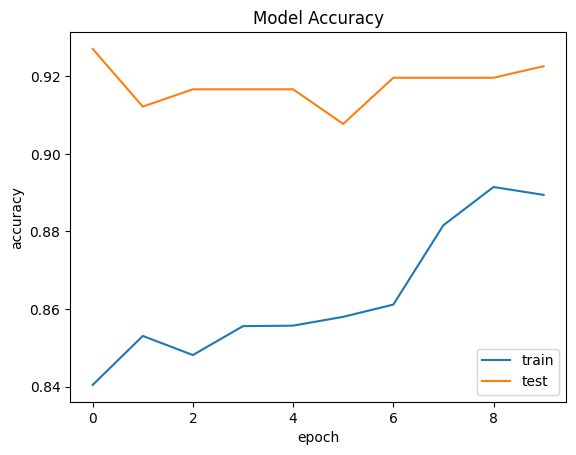

In [167]:
%matplotlib inline
# Model accuracy
plt.plot(logs.history['accuracy'])
plt.plot(logs.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

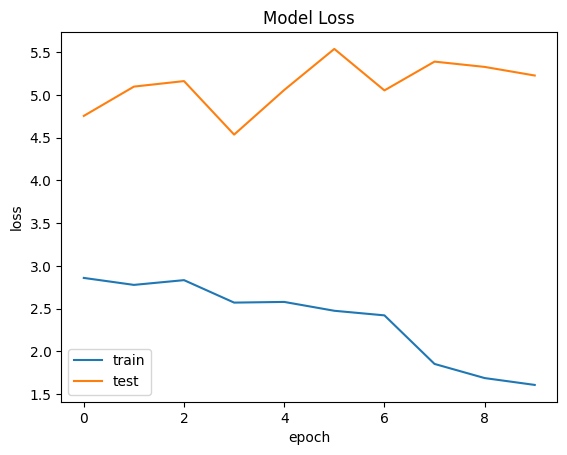

In [168]:
# Model Losss
plt.plot(logs.history['loss'])
plt.plot(logs.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [172]:
# full path for saving the model
save_dir = "saved/"

# Ensure the directory exists (create it if it doesn't)
os.makedirs(save_dir, exist_ok=True)

# Save the model in the TensorFlow SavedModel format
model.save(os.path.join(save_dir, 'model'), save_format='tf')

INFO:tensorflow:Assets written to: saved/model\assets


INFO:tensorflow:Assets written to: saved/model\assets


In [19]:
import IPython.display as display

def predictor(image_path):
    # Load the image
    img = load_img(image_path, target_size=(224, 224))  # Adjust target_size as needed
    display.display(img)

    # Convert the image to a NumPy array
    arr = img_to_array(img)
    arr = arr / 255.0
    arr = np.expand_dims(arr, 0)

    # Make predictions using the model
    predictions = model.predict(arr)
    print(predictions.shape)

    # Get the index with the highest probability
    idx = np.argmax(predictions)

    # Return the predicted label and probability
    return label_mapper[idx], predictions[0][idx]

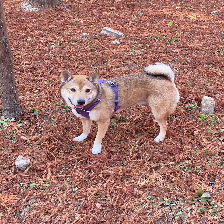

1/1 [==============================] - 0s 50ms/step
(1, 70)
('Shiba Inu', 1.0)


In [21]:
result = predictor('daidai.jpg')
print(result)